Iterative workflow example, Tweet generation by multiple evaultion and generation cycle for best output

In [ ]:
import os
os.environ["GOOGLE_API_KEY"] = "api key here"

In [158]:
from langgraph.graph import StateGraph,START,END
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import HumanMessage, SystemMessage
from dotenv import load_dotenv
from typing import TypedDict,Literal,Annotated
from pydantic import BaseModel, Field
load_dotenv()

False

In [159]:
import operator
class State_Schema(TypedDict):
    user_input: str
    generated_tweet: str
    feedback:str
    evaluation: Literal["approved", "needs_improvement"]
    iteration: Annotated[int, operator.add]
    max_iterations: int

In [160]:
llm=ChatGoogleGenerativeAI(model="gemini-2.5-flash", temperature=0.2)

In [161]:
## node fucntions

def generate_tweet(state: State_Schema) -> State_Schema:
    prompt = [
        SystemMessage("You are a social media expert specialized in crafting engaging tweets."),
        HumanMessage(f"""Create a very basic and simple  single  tweet which is not that great in terms of clarity and thinking  based on the following input: {state["user_input"]}.""")
    ]
    response=llm.invoke(prompt).content
    return {"generated_tweet": response}


class evaluation_output(BaseModel):
    evaluation: Literal["approved", "needs_improvement"]
    feedback: str = Field( description="Detailed feedback on the tweet.")


def evaluator(state: State_Schema) -> State_Schema:
    prompt = [
        SystemMessage("You are a meticulous tweet evaluator."),
        HumanMessage(f"""Evaluate the following tweet: {state["generated_tweet"]}.
        If it meets high standards of engagement and clarity, respond with "approved". be critical and provide specific feedback for improvement.
        Otherwise, if the tweet doesn't meet the standards, respond with "needs_improvement"   and generate feedback.""")
    ]
    response=llm.with_structured_output(evaluation_output).invoke(prompt)
    return {"evaluation": response.evaluation, "feedback": response.feedback, "iteration":state["iteration"]+1}


terminate=lambda state: state

def check_evaluation(state: State_Schema)->Literal["terminate","optimizer"]:
    if state["evaluation"] == "approved" or state["iteration"] >= state["max_iterations"]:
        return "terminate"
    else:
        return "optimizer"
    
def optimizer(state: State_Schema) -> State_Schema:
    prompt = [
        SystemMessage("You are a skilled tweet optimizer."),
        HumanMessage(f"""Optimize the following tweet based on this feedback: {state["feedback"]}.
        Original Tweet: {state["generated_tweet"]}.""")
    ]
    response=llm.invoke(prompt).content
    return {"generated_tweet": response}




In [169]:
graph=StateGraph(State_Schema)
graph.add_node("generate_tweet", generate_tweet)
graph.add_node("evaluator", evaluator)
graph.add_node("optimizer", optimizer)
graph.add_node("terminate", terminate)

In [170]:
graph.add_edge(START, "generate_tweet")
graph.add_edge("generate_tweet", "evaluator")
graph.add_conditional_edges("evaluator", check_evaluation)
graph.add_edge("terminate", END)
graph.add_edge("optimizer", "evaluator")

In [ ]:
workFlow=graph.compile()


In [165]:
result=workFlow.invoke({'user_input':"give a review of animal movie","max_iterations":3,"iteration":0})
print(result)

ChatGoogleGenerativeAIError: Error calling model 'gemini-2.5-flash' (RESOURCE_EXHAUSTED): 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/usage?tab=rate-limit. \n* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 20, model: gemini-2.5-flash\nPlease retry in 15.814552919s.', 'status': 'RESOURCE_EXHAUSTED', 'details': [{'@type': 'type.googleapis.com/google.rpc.Help', 'links': [{'description': 'Learn more about Gemini API quotas', 'url': 'https://ai.google.dev/gemini-api/docs/rate-limits'}]}, {'@type': 'type.googleapis.com/google.rpc.QuotaFailure', 'violations': [{'quotaMetric': 'generativelanguage.googleapis.com/generate_content_free_tier_requests', 'quotaId': 'GenerateRequestsPerDayPerProjectPerModel-FreeTier', 'quotaDimensions': {'model': 'gemini-2.5-flash', 'location': 'global'}, 'quotaValue': '20'}]}, {'@type': 'type.googleapis.com/google.rpc.RetryInfo', 'retryDelay': '15s'}]}}

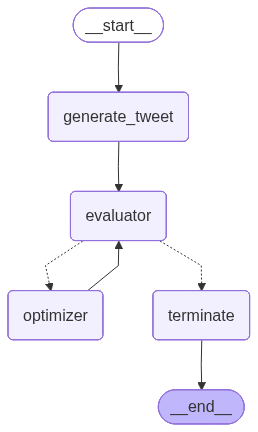

In [172]:
from IPython.display import Image
Image(workFlow.get_graph().draw_mermaid_png())